# Topic Modeling — With Tomotopy

In these lessons, we're learning about a text analysis method called *topic modeling*. This method will help us identify the main topics or discourses within a collection of texts or single text that has been separated into smaller text chunks.

In this particular lesson, we're going to use [Tomotopy](https://github.com/bab2min/tomotopy) to topic model 379 obituaries published by *The New York Times*.

While Mallet is a fantastic tool that is widely embraced throughout the DH community, it can also pose challenges for scholars because it requires the installation and configuration of Mallet/the Java Development Kit. Tomotopy is a topic modeling tool that is written purely in Python, and it seems to be a good alternative to Mallet.

___

## Dataset

### *New York Times* Obituaries

<blockquote class="epigraph" style=" padding: 10px">

 Georgia O'Keeffe, the undisputed doyenne of American painting and a leader, with her husband, Alfred Stieglitz, of a crucial phase in the development and dissemination of American modernism, died yesterday at St. Vincent Hospital in Santa Fe, N.M.

<p class ="attribution">
    —Edith Evans Asbury, <a href="https://www.nytimes.com/1986/03/07/obituaries/georgia-o-keeffe-dead-at-98-shaper-of-modern-art-in-us.html">Georgia O'Keefe Dead At 98</a>
    </p>
    
</blockquote>

This dataset is based on data originally collected by Matt Lavin for his *Programming Historian* [TF-IDF tutorial](https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf#lesson-dataset). I have re-scraped the obituaries so that the subject's name and death year is included in each text file name, and I have added 13 more ["Overlooked"](https://www.nytimes.com/interactive/2018/obituaries/overlooked.html) obituaries, including [Karen Spärck Jones](https://www.nytimes.com/2019/01/02/obituaries/karen-sparck-jones-overlooked.html), the computer scientist who introduced TF-IDF.

___

## Install Packages

In [ ]:
!pip install tomotopy

## Import Packages

Now let's import `tomotopy`, `little_mallet_wrapper` and the data viz library `seaborn`.

We're also going to import [`glob`](https://docs.python.org/3/library/glob.html) and [`pathlib`](https://docs.python.org/3/library/pathlib.html#basic-use) for working with files and the file system.

In [2]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path

## Get Training Data From Text Files

Before we topic model the *NYT* obituaries, we need to process the text files and prepare them for analysis. The steps below demonstrate how to process texts if your corpus is a collection of separate text files. In the next lesson, we'll demonstrate how to process texts that come from a CSV file.

<div class="admonition note" name="html-admonition" style="background: lightblue; padding: 10px">
    
<p class="title">Note</p>
    
We're calling these text files our *training data*, because we're *training* our topic model with these texts. The topic model will be learning and extracting topics based on these texts.
    
</div>

To get the necessary text files, we're going to make a variable and assign it the file path for the directory that contains the text files.

In [3]:
directory = "../texts/history/NYT-Obituaries/"

Then we're going to use the `glob.gob()` function to make a list of all (`*`) the `.txt` files in that directory.

In [4]:
files = glob.glob(f"{directory}/*.txt")

Next we process our texts with the function `little_mallet_wrapper.process_string()`.

This function will take every individual text file, transform all the text to lowercase as well as remove stopwords, punctuation, and numbers, and then add the processed text to our master list `training_data`.

In [8]:
training_data = []
original_texts = []
titles = []

for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)
    original_texts.append(text)
    titles.append(Path(file).stem)

In [9]:
len(training_data), len(original_texts), len(titles)

(379, 379, 379)

## Train Topic Model

In [85]:
# Number of topics to return
num_topics = 15
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())
    
print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

print("\nTopic Model Results:\n\n")
# Print out top 10 words for each topic
topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")

Topic Model Training...


Iteration: 0	Log-likelihood: -10.147201521861968
Iteration: 10	Log-likelihood: -9.782205299903422
Iteration: 20	Log-likelihood: -9.647394965920114
Iteration: 30	Log-likelihood: -9.579161044754324
Iteration: 40	Log-likelihood: -9.523919459170235
Iteration: 50	Log-likelihood: -9.486029305400086
Iteration: 60	Log-likelihood: -9.451744556960438
Iteration: 70	Log-likelihood: -9.422499595850962
Iteration: 80	Log-likelihood: -9.393694151871706
Iteration: 90	Log-likelihood: -9.373238453748217

Topic Model Results:


✨Topic 0✨

justice mao people china one communist court wrote warren many

✨Topic 1✨

music band jazz musical sinatra played years neill big became

✨Topic 2✨

miss mrs new said york women died years woman black

✨Topic 3✨

art paris work music works moses artist picasso new century

✨Topic 4✨

film said won theater films movie broadway hollywood television movies

✨Topic 5✨

president general house roosevelt grant state gen office law republican

✨Topic 6

## Examine Top Documents and Titles

Load topic distributions

In [102]:
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

Make functions for displaying top documents. The `get_top_docs()` function is taken from Maria Antoniak's [Little Mallet Wrapper](https://github.com/maria-antoniak/little-mallet-wrapper/blob/c89bfbeddb11ddc2a6874476985275a7b2a6c1fd/little_mallet_wrapper/little_mallet_wrapper.py#L164)

In [243]:
from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):
    
    sorted_data = sorted([(_distribution[topic_index], _document) 
                          for _distribution, _document 
                          in zip(topic_distributions, docs)], reverse=True)
    
    topic_words = topics[topic_index]
    
    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n---")
    
    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)
        
        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')
    
    return

Display top titles

In [244]:
get_top_docs(titles, topic_distributions, topic_index=0, n=6)

### ✨Topic 0✨

justice mao people china one communist court wrote warren many

---

✨  
**Topic Probability**: 0.2971937954425812  
**Document**: 1976-Mao-Tse-Tung



✨  
**Topic Probability**: 0.25366345047950745  
**Document**: 1974-Earl-Warren



✨  
**Topic Probability**: 0.24932962656021118  
**Document**: 1993-Thurgood-Marshall



✨  
**Topic Probability**: 0.24574586749076843  
**Document**: 2000-Pierre-Trudeau



✨  
**Topic Probability**: 0.23010674118995667  
**Document**: 1989-Andrei-Sakharov



✨  
**Topic Probability**: 0.22531503438949585  
**Document**: 1975-Chiang-Kai-shek



In [245]:
get_top_docs(titles, topic_distributions, topic_index=1, n=5)

### ✨Topic 1✨

music band jazz musical sinatra played years neill big became

---

✨  
**Topic Probability**: 0.5446100831031799  
**Document**: 1983-Earl-Hines



✨  
**Topic Probability**: 0.5283928513526917  
**Document**: 1993-Dizzy-Gillespie



✨  
**Topic Probability**: 0.4744018316268921  
**Document**: 1986-Benny-Goodman



✨  
**Topic Probability**: 0.4569990336894989  
**Document**: 1983-Muddy-Waters



✨  
**Topic Probability**: 0.4541119337081909  
**Document**: 1991-Miles-Davis



Display top documents with topic words bolded

In [246]:
get_top_docs(original_texts, topic_distributions, topic_index=1, n=5)

### ✨Topic 1✨

music band jazz musical sinatra played years neill big became

---

✨  
**Topic Probability**: 0.5446100831031799  
**Document**: April 24, 1983

 OBITUARY

 Earl Hines, 77, Father of Modern Jazz Piano, Dies

 By JON PARELES

 Earl (Fatha) Hines, the father of modern **jazz** piano, died Friday in Oakland, Calif., after a heart attack. He was 77 **years** old. In his pioneering work with Louis Armstrong in the late 1920's, Mr.

 Hines virtually redefined **jazz** piano. With what he called ''trumpet style,'' Mr. Hines **played** horn-like solo lines in octaves with his right hand and spurred them with chords from his left. He thus carved a place for the piano as a solo instrument outside the rhythm section and defined the roles of both hands for the next generations of jazz pianists.

 Mr. Hines's strong right hand and angular melodic ideas continued to sound contemporary throughout his career. In the 1930's and 1940's, he led a Chicago **big** **band** that began the careers of the singers Billy Eckstine and Sarah Vaughan and included the saxophonists Wardell Gray and Budd Johnson. That **band** **became** an incubator for be-bop in the early 1940's, when it featured the trumpeter Dizzy Gillespie and the saxophonist Charlie

 Parker.

 Son of Two Musicians

 Earl Hines was born in Duquesne, Pa. His father was a trumpeter and his mother **played** piano and organ. He took up the trumpet as a child, but began studying classical piano at the age of 9. After three **years** of lessons, he decided he was more interested in jazz piano, and by the time he was 15 years old he was leading his own trio.

 Mr. Hines worked with **big** bands led by Lois B. Deppe in Pittsburgh and Carroll Dickerson and Sammy Stewart in Chicago, and in 1927 he joined a quintet led by Louis Armstrong at Chicago's Savoy Ballroom.

 With Mr. Armstrong, he made such recordings as ''West End Blues'' and ''Weather Bird,'' and in 1928 he recorded solos, including ''A Monday Date'' and ''Caution Blues,'' that established his style and have had a lasting influence on jazz piano.

 Mr. Hines started his own big band in 1928 at Chicago's Grand Terrace Ballroom, and stayed in residence there for more than a decade, although he toured for part of each year. His was one of the first black big bands to tour the South.

 Thn ''Jelly Jelly'' and ''Stormy Monday Blues.'' Although he left the Grand Terrace in 1940, Mr. Hines led a big band nearly continuously until 1947; at one point the group included a string section composed entirely of women.

 Origin of Nickname

 A Chicago disk jockey called him ''Fatha'' in the 1930's and the nickname - as in ''Father of modern piano'' -stayed with him. After dissolving his band, Mr. Hines worked with smaller groups. He rejoined Mr.

 Armstrong from 1948 to 1951, then led his own bands. In 1957, he toured Europe with an all-star group including the trombonist Jack Teagarden, but he spent much of the 1950's playing Dixieland jazz - **music** that he had not be Jack Teagarden, but he spent much of the 1950's playing Dixieland jazz - **music** that he had not been a part of - on the West Coast.

 He re-emerged with triumphant concerts and recordings in the early 1960's, and was elected a member of Downbeat magazine's jazz hall of fame in 1965. In 1966, the United States sponsored Mr. Hines' group on a tour of the Soviet Union, where he played for 92,000 people.

 Since the 1950's, Mr. Hines had been based in the San Francisco Bay area, and he continued to tour Europe, Japan and the United States through the early 1980's. He played his final engagement last weekend in San Francisco.

 Mr. Hines is survived by a granddaughter. He was divorced from his wife, Janie, in 1980.

 





✨  
**Topic Probability**: 0.5283928513526917  
**Document**: January 7, 1993

 OBITUARY

 Dizzy Gillespie, Who Sounded Some of Modern Jazz's Earliest Notes, Dies at 75

 By PETER WATROUS

 Dizzy Gillespie, the trumpet player whose role as a founding father of modern **jazz** made him a major figure in 20th-century American **music** and whose signature moon cheeks and bent trumpet made him one of the world's most instantly recognizable figures, died yesterday at Englewood Hospital in Englewood, N.J.

 Mr. Gillespie, who was 75, had been suffering for some time from pancreatic cancer, his press agent, Virginia Wicks, said.

 In a nearly 60-year career as a composer, **band** leader and innovative player, Mr. Gillespie cut a huge swath through the **jazz** world. In the early 40's, along with the alto saxophonist Charlie (Yardbird) Parker, he initiated be-bop, the sleek, intense, high-speed revolution that has become jazz's most enduring style. In subsequent **years** he incorporated Afro-Cuban **music** into jazz, creating a new genre from the combination.

 In the naturally effervescent Mr. Gillespie, opposites existed. His playing -- and he performed constantly until nearly the end of his life -- was meteoric, full of virtuosic invention and deadly serious.

 But with his endlessly funny asides, his huge variety of facial expressions and his natural comic gifts, he was as much a pure entertainer as an accomplished artist. In some ways, he seemed to sum up all the possibilities of American popular art.

 From Carolina To the Big Bands

 John Birks Gillespie was born in Cheraw, S.C., on Oct. 21, 1917. His father, a bricklayer, led a local **band**, and by the age of 14 the young Gillespie was practicing the trumpet. He and his family moved to Philadelphia two **years** later, and Mr. Gillespie, though he thought about entering Temple University, quickly began a succession of professional jobs.

 He worked with Bill Doggett, the pianist and organist, who fired him for not being able to read music well enough, and then Frank Fairfax, a **big**-band leader whose orchestra included the trumpeter Charlie

 Shavers and the clarinetist Jimmy Hamilton. Mr. Gillespie was listening to the trumpeter Roy Eldridge, copying his solos and emulating his style, and was soon performing with Teddy Hill's band at the Savoy Ballroom on the basis of his ability to reproduce Mr. Eldridge's style.

 According to legend, it was Mr. Hill who gave Mr. Gillespie his nickname because of his odd clothing style and his fondness for practical jokes. Mr. Gillespie began cultivating his personality, putting his feet up on music stands during shows and regularly cracking jokes. But by May 1937 he was also recording improvisations with the Hill band and helping the performances by setting riffs behind soloists.

 Two years later, Mr. Gillepsie was considered accomplished enough to take part in a series of all-star recordings with Lionel Hampton, Benny Carter, Coleman Hawkins, Ben Webster and Chu Berry. He soloed on "Hot Mallets."

 That year, 1939, he joined Cab Calloway's band, one of the leading black orchestras of the era. Though a dance band, its musicians, who included the bassist Milt Hinton and the guitarist Danny Barker, liked to experiment. Mr. Gillespie would work on the harmonic substitutions that eventually **became** be-bop. Mr. Gillespie was a regular soloist with the band, and by then his harmonic sensibility was beginning to take shape.

 Joining With Parker To Mold New Style

 It was while touring with the Calloway band in 1940 that Mr. Gillespie met Charlie Parker in Kansas City. And it was with him that Mr. Gillespie began formulating the style that was eventually called be-bop. Along with a handful of other musicians, including Thelonious Monk and Kenny Clarke, Mr. Gillespie and Mr. Parker would regularly experiment.

 On live recordings of the period, especially the two solos on the tune "Kerouac," recorded in 1941 at Minton's Uptown Playhouse, a club in Harlem, can be heard his increasing interest in harmony, sleeker rhythms and a divergence from the style of Mr. Eldridge. Mr. Gillespie was blunt about his relationship with Mr. Parker, calling him "the other side of my heartbeat," and freely giving him credit for some of the rhythmic innovations of be-bop.

 At the same time that Mr. Gillespie was experimenting with the new style, he was regularly arranging and recording for Mr. Calloway, including one of his better improvisations on "Pickin' the

 Cabbage," a piece he composed and arranged. In September 1941, at the State Theater in Hartford, Mr. Gillespie was involved in an incident that shaped his reputation and his career. Mr. Calloway saw a spitball thrown on stage and thought Mr. Gillespie had done it; the two men fought, and Mr. Gillespie pulled a knife and put a cut in Mr. Calloway's posterior that required 10 stitches to close.

 Mr. Gillespie was fired from that job, but spent the next several years working with some of the biggest names in jazz, including Coleman Hawkins (who recorded the first version of Mr. Gillespie's classic "Woody 'N' You"), Benny Carter, Les Hite (for whom he recorded "Jersey Bounce," considered the first be-bop solo), Lucky Millinder, Earl Hines, Ella Fitzgerald and Duke Ellington. For Mr. Millinder he made "Little John Special," which includes a riff of Mr. Gillespie's that was later fleshed out into the composition "Salt Peanuts," one of his best-known pieces.

 The early 40's were a turbulent time for jazz. Be-bop was slowly making itself felt, but at the same time a series of disputes between recording companies and the musicians' union resulted in a recording ban, so Mr. Gillespie and Mr. Parker were rarely recorded. In 1943 Mr. Gillespie led a band with the be-bop bassist Oscar Pettiford at the Onyx Club on 52d Street in Manhattan. And in 1944, the singer Billy Eckstine took over part of the Earl Hines band and created the first be-bop orchestra, of which few recorded performaces exist. Mr. Gillespie was the music director, and the band featured his "Night in Tunisia."

 It was in 1945 that Mr. Gillespie began to break out. He undertook an ambitious recording schedule, recording with the pianist Clyde Hart and with Mr. Parker, Cootie Williams, Red Norvo, Sarah Vaughan and Slim Gaillard. And he began series of his own recordings that have since become some of jazz's most important pieces.

 Recording under his own name for the first time, he made "I Can't Get Started," "Good Bait," "Salt Peanuts" and "Be-bop," during one session in January 1945.

 He followed it up with a recording date featuring Mr. Parker that included "Groovin' High," "Dizzy Atmosphere" and "All the Things You Are."

 These recordings, with their tight ensemble passages, precisely articulated rhythms and dissonance as part of the palate of jazz, were to influence jazz forever. Though Mr. Gillespie enjoyed playing for dancers, this was music that was meant first and foremost to be listened to. It was virtuosic in a way not heard before, and it was music that sent music students scurrying to their turntables to learn the improvisations by heart.

 They were also the recordings that captured Mr. Gillespie at his most impressive. His lines, jagged and angular, always seemed off balance. He used chromatic figures, and was not afraid to resolve a line on a vinegary, bitter note. And his improvising was eruptive; suddenly, a line would bolt into the high register, only to come tumbling down.

 Mr. Gillespie did more than just record in 1945. He put together the first of his **big** bands, and then formed a quintet with Mr. Parker that Mr. Gillespie called "The height of perfection in our music." It included Bud Powell on piano, Ray Brown on bass and Max Roach on drums. Later that year, Mr. Gillespie reformed the big band, called the Hepsations of 1945. Despitea tour of the South that was almost catastrophically unsuccessful, the band stayed together for the next four years. Another Revolution: Afro-Cuban Jazz

 It was with this big band, whose name **became** the Dizzy Gillespie Orchestra, that Mr. Gillespie created his second revolution in the late 1940's. An old friend, the Cuban trumpeter Mario Bauza, who had made it possible for him to join the Calloway orchestra, introduced Mr. Gillespie to the Cuban conga player Luciano (Chano Pozo) Gonzales. "Dizzy used to ask me about Cuban rhythms all the time," said Mr. Bauza. "I introduced him to Chano Pozo, and they wrote 'Manteca.' It was a good marriage of two cultures. That was the beginning of Afro-Cuban jazz. That blew up the whole world."

 Mr. Gillespie quickly produced the sketches for "Cubana Be" and "Cubana Bop," which were finished by the composer and arranger George Russell and included some of the first modal harmonies in jazz. And in "Manteca," Mr. Gillespie's collaboration with Mr. Pozo, he created a work that is still performed and quoted regularly, by both Latin orchestras and by jazz musicians. Without the sophisticated arrangements and the conjunction of Latin rhythms and jazz harmonies that Mr. Gillespie provided, both jazz and Latin music would be radically different today.

 The band's highest moments, however, were when Mr. Gillespie -- in a move that characterized his career -- hired some of the young be-boppers on the scene. Among them were the pianist John Lewis, vibraphonist Milt Jackson, bassist Ray Brown and drummer Kenny Clarke, who went on to form the Modern Jazz Quartet. "It was an incredible experience because so much was going on," Mr. Lewis recalled. "Not only was he using these great be-bop arrangements but he was so encouraging. It was my first job, a formative experience."

 Mr. Gillespie's was the last great evolutionary big band, and during its tenure he hired the best soloists, from Jimmy Heath, James Moody and Sonny Stitt to John Coltrane and Paul Gonzalves. Arrangements like "Things to Come," with their exhilarating precision, were be-bop and orchestral landmarks, with dense harmonies and flashy rhythms.

 And it was with his big band that Mr. Gillespie fully developed the other side of his **musical** personality. With songs like "He Beeped When He Should Have Bopped," "Ool Ya Koo", "Oo

 Pop A Da" and others, he began popularizing the Bohemian, Dadaesque aspects of be-bop.

 Mr. Gillespie was a keen popularizer, and with his sense of comedy managed to make his shows into an extraordinary mixture of entertainment and esthetics. In so doing, he was following in the path of his ex-bandleader, Mr. Calloway, as well as Louis Armstrong and Fats Waller.

 From then on, he cultivated an audience that went beyond the average jazz fan, and it was this reputation that helped in his later career. And at the same time, be-bop fashion made an appearance, with Mr. Gillespie, in thick glasses and a beret, leading the way.

 The big-band business slowed down considerably in the late 1940's and early 50's, and Mr. Gillespie teamed with Stan Kenton's orchestra as a featured soloist. Then he began using a small group again.

 He formed his own record company in 1951, Dee Gee, which folded soon after. Mr. Gillespie and Mr. Parker recorded for Verve, with Mr. Monk, and he and Mr. Parker performed at Birdland in Manhattan the next year. He toured Europe and in 1953 joined Mr. Parker, Mr. Powell, Mr. Roach and the bassist Charles Mingus for a concert at Massey Hall in Toronto that became legendary for its disorganization and for acrimony among performers.

 It was also in 1953 that someone fell on Mr. Gillespie's trumpet, and bent it. When he **played** the misshapen instrument, Mr. Gillespie found he could hear the sound more clearly, and so decided to keep it. Along with those cheeks, it became his trademark.

 During the 1950's Mr. Gillespie recorded with with Stan Getz, Stuff Smith, Sonny Stitt, Mr. Eldridge and others. In 1956, he formed another big band and, at the behest of the United States State

 Department, toured the Middle East and South America. In 1957, Mr. Gillespie presided over "The Eternal Triangle," a recording that includes Mr. Stitt and Sonny Rollins and some of the hardest trumpet blowing ever recorded.

 Through the 1960's and 70's, Mr. Gillespie toured frequently, playing up to 300 shows a year, sometimes with an electric bassist and a guitarist, sometimes with a more traditional group. And in 1974 he signed with Pablo Records and began recording prolifically again. He won Grammies in 1975 and 1980, and he published his autobiography, "To Be or Not to Bop," in 1979.

 In the last decade, Mr. Gillespie's career seemed recharged, and he became ubiquitous on the concert circuit as a special guest. He formed a Latin big band that performed with Paquito De Rivera, among others, and he constantly shuffled the personnel of his small groups.

 Last year, in honor of his 75th birthday, Mr. Gillepsie **played** for four weeks at the Blue Note club in Manhattan, a stint that featured perhaps the greatest selection of jazz musicians ever brought together for a tribute. The month covered his career, from small groups, to Afro-Cuban jazz to a big band. As usual, he was his witty amiable self, in command of both the audience and his trumpet.

 Mr. Gillespie is survived by his wife of 52 years, Lorraine.

 Seeking the Best Of a Huge Output

 Dizzy Gillespie's recorded output was immense, spanning nearly 60 years and comprising hundreds of albums. Not all of his important recordings have been issued on CD, but the vinyl versions are worth hunting for.

 Afro Cuban Jazz Verve The Be-Bop Revolution RCA Bird and Diz Verve The Development of an American Artist Smithsonian Diz and Getz Verve Dizzy and the Double Six of Paris Phillips

 Dizzy at Newport Verve Dizzy on the French Riviera Phillips Dizzy's Diamonds Verve Duets Verve The Gifted Ones (with Roy Eldridge) Pablo Live at the Royal Festival

 Hall Enja Oscar Peterson and Dizzy Gillespie Pablo Portrait of Duke Ellington Verve Shaw Nuff Musicraft Sonny Side Up (with Sonny Stitt) Verve

 





✨  
**Topic Probability**: 0.4744018316268921  
**Document**: June 14, 1986

 OBITUARY

 BENNY GOODMAN, KING OF SWING, IS DEAD

 By JOHN S. WILSON

 Benny Goodman, the King of Swing whose clarinet led a generation of **music** fans into the Big Band era in the 1930's, died yesterday afternoon at his Manhattan apartment, apparently of a heart attack.

 He was 77 **years** old.

 The death of the man who brought **jazz** to Carnegie Hall and enthralled millions with renditions of ''Sweet Georgia Brown'' and ''Stompin' at the Savoy'' brought expressions of grief and loss from his colleagues.

 Lionel Hampton, the vibraphonist, recalled that Mr. Goodman was the first major **music** figure to put black and white musicians together on stage in the 1930's. ''The most important thing that Benny Goodman did,'' he said, ''was to put Teddy Wilson and me in the quartet. It was instant integration. Black people didn't mix with whites then. Benny introduced us as Mr. Lionel Hampton and Mr. Teddy Wilson. He opened the door for Jackie Robinson. He gave music character and style.''

 Apple Cheeks and Horn-Rims

 The tall, apple-cheeked bandleader with the horn-rimmed glasses had had a pacemaker implanted in 1984, but he had been active and about town in recent months, and had appeared to be in good health yesterday morning, according to Lloyd Rauch, his personal assistant.

 Mr. Goodman apparently died while taking a nap on a guest-room couch in his apartment at 200 East 66th Street. The body was found by a housekeeper, Anna Lekander, Mr. Rauch said.

 Mr. Goodman **became** the King of Swing the night of Aug. 21, 1935, at the Palomar Ballroom in Hollywood. In the following **years**, he drew throngs to nightclubs and theaters and introduced **jazz** to Carnegie Hall, toured the world as a representative of a distinctive

 American culture, was instrumental in breaking the barrier that had kept white and black **musical** groups separate and developed a **band** that was a training ground for many other **band** leaders, including

 Harry James, Gene Krupa, Lionel Hampton and Teddy Wilson.

 Last month, Mr. Goodman was awarded an honorary Doctor of Music degree at Columbia University's commencement ceremonies, the latest in a long list of honors that included lifetime achievement awards at the Grammy show in February and from the Kennedy Center in Washington in 1982.

 But when he arrived at the Palomar in the summer of 1935 with a 14-piece band that he had formed a year before, there was no aura of success around Mr. Goodman. He was, in fact, so discouraged that he was prepared to give up his band and return to freelancing. His career as a band leader had been discouraging. His orchestra had been dismissed from the only two engagements it had had in New York and, after completing a 26-week contract on a network radio program, it had set out on a cross-country trek from New York to California. The reaction to Mr. Goodman's repertory of jazz-based arrangements ranged from bewilderment to antipathy. ''I thought we'd finish the engagement in California and take the train back to New York and that would be it,'' he recalled many years later. ''I'd just be a clarinetist again.''

 He Might Fail, But on His Own Terms

 He had tried to adapt to what he had been told the audiences wanted - pop tunes and waltzes. But on this night at the Palomar, starting what he thought would be the band's last engagement, Mr. Goodman decided that if he were going to fail, he would fail on his own terms. He brought out some of his favorite arrangements - by Fletcher Henderson of ''Sugar Foot Stomp,'' ''Blue

 Skies,'' ''Sometimes I'm Happy'' and ''King Porter Stomp'' - which had been his reason for recruiting a band that included such jazz specialists as the trumpeter Bunny Berrigan, the pianist Jess Stacy and the drummer Gene Krupa.

 As he beat out the tempo for ''Sugar Foot Stomp,'' the band dug into the Henderson arrangement. Then Mr. Berrigan rose up in the trumpet section, playing a crackling solo. As the sound of his horn exploded across the ballroom, a responsive roar went up from the listeners and they surged around the bandstand, cheering.

 Mr. Goodman looked around in amazement. He was stunned by the sudden change but, he said later, that roar ''was one of the sweetest sounds I ever heard in my life.''

 This stunning reversal in audience acceptance in Hollywood has been attributed to two factors. Although the ''Let's Dance'' program was on the air for only three hours, the bands actually **played** for five hours because, in those pretape days, the program had to be **played** a second time for the West Coast. By the time young listeners in California heard the Goodman band, it was warmed up and bringing out its best arrangements.

 Calfiornia was also developing a new type of radio entertainer, the disk jockey. The first celebrity disk jockey was Al Jarvis in Los Angeles, who had a program of recordings called ''The Make

 Believe Ballroom'' (a title later used in New York by Martin Block). Mr. Jarvis had been plugging the Goodman band's records and, when the band reached the Palomar, the audience, thanks to Mr. Jarvis, knew and was anxious to hear his choice Henderson arrangements.

 The crowd's roar would follow him for years at precedent-setting events not only during the swing era, which lasted into the mid-1940's, but also decades later when, in the 60's, he toured the Soviet Union with his band. He heard that same sound at the ''Paramount riot,'' in March 1937, when he played at the Paramount Theater in New York for the first time.

 Teenagers, who had followed the band on radio and had bought its records but could not afford the prices of such places as the Manhattan Room of the Hotel Pennsylvania, where the band usually played, were lined up around the theater at 6 A.M. to get into the morning show for 35 cents. During that day, more than 21,000 people jammed into the theater to bounce deliriously in the seats or shag in the aisles and battle ushers as they made desperate lunges toward the stage.

 First Jazz Concert At Carnegie Hall

 Mr. Goodman heard it again in January 1938, when, looking stiff and uncomfortable in white tie and tails, he led his orchestra in the first jazz concert ever given in Carnegie Hall to an audience that showed its enthusiasm by beating out the band's rhythm with pounding feet that rocked the old hall's balconies.

 There had been **big** bands that played swinging dance music before Mr. Goodman organized his orchestra. Fletcher Henderson led a groundbreaking black jazz band in the mid-20's, and in his wake came

 Duke Ellington, Earl Hines and Jimmie Lunceford, all black. There had also been **big**, jazz-oriented white bands - Jean Goldkette's Orchestra, the Casa Loma Orchestra and the band in which Mr.

 Goodman began playing when he was 16 years old, Ben Pollack's Orchestra.

 But Mr. Goodman's band arrived at a moment when the public's ear had been attuned by these earlier bands. Mr. Goodman provided a blend of jazz and contemporary popular music that filled this demand so successfully that, for a brief period, jazz and popular music were one and the same. His band also represented a blend of the freedom of jazz improvisation and the discipline that Mr. Goodman demanded from his musicians and, even more, from himself. He practiced his clarinet, his trumpeter Harry James once said, ''15 times more than the whole band combined.'' ''All the time I was with Goodman, he was never satisfied,'' Jess Stacy, the pianist, once said. ''With him, perfection was just around the corner. I figure Benny will die in bed with that damn clarinet.''

 In rehearsal or performance, Mr. Goodman's musicians dreaded ''the ray'' - a long, accusatory, poker-faced glare over the top of his glasses at anyone who had committed a false **musical** move. ''If you're interested in music,'' Mr. Goodman once said, ''you can't slop around. I expected things and they had to be done.''

 This discipline and his feeling for tempo produced performances that audiences that had not been exposed to much jazz found more exciting than the looser, more deeply jazz-flavored playing of Mr. Henderson's band, in which many of Mr. Goodman's most popular arrangements originated. ''Benny was very conscious of tempos,'' Willard Alexander, a booking agent who was one of the band's earliest supporters, once said. ''His music had a kind of lilt, a feel. I remember one time we dropped into the Roosevelt

 Grill when Guy Lombardo was playing there. Benny said to me, 'You know, this Lombardo's got something.' I thought he was putting me on. But he wasn't. 'You know his secret,'

 Benny said. 'He never plays a song in the wrong tempo.' '' 'No Glamour, No Sex Appeal' ''Benny was a phenomenon,'' Mr. Alexander went on. ''He was not really the biggest band of the swing era. Glenn Miller was. But Benny was the biggest new thing in this type of presentation. He was even different physically, contrary to what everybody expected in a band leader. No glamour. No sex appeal. But a well-grounded musician. Once he hit, in came the others in the same pattern. Tommy Dorsey, Glenn Miller. Like Goodman, they were not the typical Hollywood glamour boys. They wore glasses. They had musical experience. They were not young or green. And they had a lot of background.''

 Mr. Goodman's background went back to Chicago, where he was born on May 30, 1909, the eighth of 12 children in the family of an immigrant tailor who rarely earned more than $20 a week. He was 10 when he got a clarinet on loan from a local synagogue that also provided music lessons. His brother, Harry, the biggest of the Goodman boys, was given a tuba. Freddy, the next largest, received a trumpet. In later years, Benny Goodman wondered what kind of career he might have had ''if I had been 20 pounds heavier and two inches taller.''

 When he was 12, the youth won $5 at a Chicago theater doing an imitation of Ted Lewis, and by the time he was 14 he was making $48 a week playing four nights in the neighborhood band. He also played in the band at Hull House, the celebrated Chicago settlement house, and studied for two years with Franz Shoepp, a clarinetist in the Chicago Symphony, a strict disciplinarian who, Mr. Goodman said, ''did more for me musically than anyone I ever knew.''

 Still wearing short pants, he **became** part of a clique of teenage jazz musicians that included the cornetist Jimmy McPartland, the saxophonist Bud Freedman and the drummer Dave Tough, who were fascinated by the jazz sounds that flowed through Chicago in the 20's. He absorbed in his own playing the beautiful tone and sparkling flow of Jimmie Noone, the clarinetist. 'Kid in Short Pants' Is Summoned

 Leon Rappolo, clarinetist in the New Orleans Rhythm Kings, who leaned so far back in his chair when he played that he seemed to be lying down, influenced both Mr. Goodman's style and his posture.

 When Ben Pollack, the drummer in the Rhythm Kings, formed a band in California, he sent back to Chicago for ''the kid in the short pants, the kid who played lying down, like Rappolo.''

 Mr. Goodman was 16 when he joined the Pollack band in Venice, Calif., in 1926. He remained in the band for four years, when Glenn Miller, Jack Teagarden, Bud Freeman, Jimmy McPartland and Mr. Goodman's brother, Harry, were in the band. For the last two years, the Pollack band was based in New York, playing at the Little Club and at the Park Central Hotel (now the Omni-Park Hotel) and doubling in the pit of a musical, ''Hello, Daddy.''

 In the fall of 1929, after some disagreements with Mr. Pollack, Mr. Goodman left the band and began to freelance on radio and records, making as much as $350 to $400 a week in the early days of the Depression.

 In 1933, he met a young jazz fan and jazz activist, John Hammond, whose enthusiasm, insight and energy were to have a profound effect on the careers of Mr. Goodman, Billie Holiday, Count Basie and

 Charlie Christian, the short-lived, precedent-setting electric guitarist who played in Mr. Goodman's band for two years before his death in 1941.

 Mr. Hammond, who had a commission to make some jazz records for release in England, asked Mr. Goodman to lead a band for this purpose. Mr. Goodman chose some of his freelance friends, a group that Mr.

 Hammond augmented by borrowing Gene Krupa and Jack Teagarden from Mal Hallett's orchestra in Boston.

 These records, released as by ''Benny Goodman and His Orchestra,'' planted a seed that took root in 1934, when, with his freelance income reduced to $40 a week, Mr. Goodman heard that Billy Rose was auditioning bands for a new club called the Music Hall. With the help of Mr. Hammond, he started putting a band together. ''There were practically no hot bands using white musicians at the time,'' Mr. Goodman later recalled, ''and there was a lot of talent around town, both in jobs and laying off, that hadn't gotten the breaks.''

 A Tight Group, Every Man a Soloist

 His concept was a jazz band made up of young musicians who read well and played in tune, a group with a tight, small-band quality in which every man could be a soloist. The band he and Mr. Hammond assembled included Claude Thornhill, the pianist, who soon returned to studio work, and three musicians who remained with Mr. Goodman through the band's early days of glory - Red Ballard, trombonist:

 Arthur Rollini (brother of Adrian), saxophonist, and Hymie Schertzer. Mr. Schertzer's alto saxophone later gave the Goodman saxophone section its sheen, but he was hired because Mr. Goodman had heard he would need a violin in his band to accompany the shows at the Music Hall and Mr. Schertzer could play violin as well as saxophone.

 Ironically, Mr. Goodman's band was not able to play the routine accompanying music for the Music Hall's vaudeville acts - tumblers, a fire eater, a dog act - to Billy Rose's satisfaction.

 They were on the verge of being released when a compromise was reached - a second band would play for the shows and Mr. Goodman's band would play for dancing.

 Three months later, when the Music Hall's management changed, the band was let go. But before that happened, the band auditioned for a prospective three-hour weekly radio program to be divided between

 Latin music, ''sweet'' music and ''hot'' music. Xavier Cugat had already been signed as the Latin band. Murray Kellner (as Kel Murray) led the ''sweet'' band. The sponsor, the National Biscuit Company, lined up several ''hot'' bands and had some of its employes vote on them. Benny Goodman won by one vote.

 During the 26 weeks that Mr. Goodman played on this ''Let's Dance'' program, he had a budget with which to buy eight arrangements a week at $37.50 each. Edgar Sampson's $37.50 arrangement of ''Stompin' at the Savoy,'' played on the first ''Let's Dance'' broadcast, became one of Mr. Goodman's classics.

 Another arranger, Gordon Jenkins, wrote ''Goodbye,'' which became Mr. Goodman's closing theme. He also got his opening signature, ''Let's Dance,'' from the show - a ''hot'' arrangement of Carl Maria Von Weber's ''Invitation to the Dance'' written by George Bassman, who also provided a Latin version for

 Mr. Cugat and a ''sweet'' version for Mr. Kellner.

 Paying $37.50 For 'Killer-Dillers'

 But the most important collection of arrangements that Mr. Goodman got for his $37.50 came from Fletcher Henderson who, in 1934, had given up the big band he had led for 11 years. Some of these arrangements had originally been played by the Henderson band. ''King Porter Stomp'' and ''Big John Special'' were the first two, providing Mr. Goodman with the basis for the library of what became known as ''killer-dillers.'' But, at Mr. Goodman's urging, Mr. Henderson also wrote arrangements of popular songs that established the melodic and swinging style of the Goodman band. ''Fletcher's ideas were far ahead of anybody else's at the time,'' Mr. Goodman said. ''Without Fletcher, I probably would have had a pretty good band, but it would have been something quite different from what it eventually turned out to be.''

 Mr. Henderson's insistently swinging scores typify the Goodman band's style. George Simon, in his book ''The Big Bands,'' described them as ''simple, swinging arrangements in which complete sections played with the feeling of a single jazz soloist.'' ''In addition,'' Mr. Simon wrote, ''Henderson would set off one section against another, rolling saxes vs. crisp brass, an approach quite different from the less rhythmic, more lethargic-sounding ensembles of most dance bands.''

 After the ''Let's Dance'' program went off the air, Mr. Goodman's band was, inexplicably, booked into the Roosevelt Grill as a summer replacement for Guy Lombardo's ''Sweetest Music This Side of Heaven.'' Mr. Goodman's musicians had scarcely let out their first ''hot'' blast on opening night at the Roosevelt when they were given their two weeks' notice. The trail of discouragement continued as the band headed west toward California and the sudden turnaround at the Palomar Ballroom.

 First Billing As a 'Swing' Band

 So, instead of taking the train back to New York, Mr. Goodman stayed at the Palomar for two months. Then the band went to Chicago, where, booked into the Joseph Urban Room of the Congress Hotel, it stayed for six months. In Chicago it was billed for the first time as a ''swing'' band, with the word in quotes - ''as if,'' Mr. Goodman remarked, ''it was something in a foreign language.''

 The word had been used for years by musicians - Duke Ellington wrote ''It Don't Mean a Thing if It Ain't Got That Swing'' in 1932. But the general public seized on ''swing'' as a trendy catchword. However, references to Mr. Goodman as ''the King of Swing'' made him nervous. ''I didn't know how long it was going to last,'' he explained, ''and I didn't want to be tied down to something people might say was old-fashioned just because they tired of the name in a year or so.''

 But swing fever was on the rise, and in December 1935, some of Mr. Goodman's fans organized what may have been the first jazz concert. It was advertised as a ''Tea Dance'' and it was held in the Joseph Urban Room. But it was a sit-down-and-listen affair and a few people who instinctively tried to dance were booed off the floor. The response was so enthusiastic that another concert was organized for Easter Sunday in 1936. This time Mr. Goodman flew Teddy Wilson, the pianist, out to Chicago from New York.

 Less than a year before, Mr. Goodman had jammed with Mr. Wilson at the home of Mildred Bailey, the singer, accompanied on drums by Miss Bailey's cousin, Carl Bellinger. This led to some recordings by a trio made up of Mr. Goodman, Mr. Wilson and Gene Krupa, the Goodman band's drummer, made just before Mr. Goodman's fateful trip to the West Coast. This Chicago concert was the first time the trio performed in public. The performance was so successful that Mr. Goodman decided to keep Mr. Wilson and the trio as a regular part of his troupe.

 A Breakthrough In the Color Barrier

 This created a precedent, quickly copied by other swing bands, of having a small group within the big band. And by making Mr. Wilson, a black, a part of his entourage, Mr. Goodman broke through the color barrier that, until then, had kept white bands white and black bands black. A few months later, while the band was in Hollywood making its first movie, ''The Big Broadcast of 1937,''

 Mr. Goodman heard Lionel Hampton leading a band at the Paradise Cafe and, after enjoying an after-hours jam session with him, persuaded Mr. Hampton to add his vibraphone to the trio, making it a quartet that was 50 percent black.

 For the next four years the Goodman band rode on the crest of the Swing Era popularity, despite a brief challenge from another clarinet-playing leader, Artie Shaw. The cheers and shouts of approval were seemingly endless. In 1938, when the band's second film, ''Hollywood Hotel,'' opened in New York, The New York Times film critic, Frank Nugent, reported: ''You couldn't hear anything but the audience except when the picture worked its volume to a storm-warning level. It would have taken more than that, though, to override their howling when Mr. Goodman's clarinet came into camera range.''

 Not long after appearing in the film, Mr. Goodman performed with other jazz musicians in the Broadway musical ''Swingin' the Dream,'' which opened in 1939.

 The eye of the Goodman whirwind was the Hotel Pennsylvania in New York, where the band spent several months each year. When Mr. Goodman's mother came to hear his band for the first time, she looked around in amazement. ''This is the way he makes a living?'' she asked.

 In the summer of 1940, despite a steady load of engagements, Mr. Goodman broke up his band to take three months off to undergo surgery for a painful case of sciatica. When he reorganized his band in

 October of that year, the bulk of the arranging was taken over by Eddie Sauter, a trumpet player who had played and arranged for Red Norvo and who, in the 1950's, would be co-leader of an adventurous band with Bill Finegan. Mr. Finegan was making his reputation as an arranger with Glenn Miller at the very time that Mr. Sauter began arranging for the new Goodman band.

 The New Band Of the 1940's

 For this 1940's band, Mr. Goodman lured away Duke Ellington's trumpet star, Cootie Williams. He had a brilliant 18-year-old pianist, Mel Powell, and such veterans as Charlie Christian, Dave

 Tough, Billy Butterfield, Lou McGarity and Georgie Auld. In the opinion of many Goodman fanciers, this band of the early 40's, less publicized than his band of the 30's but with Mr. Sauter's provocative arrangements, was the finest of the Benny Goodman bands.

 It was during the 40's also that Mr. Goodman appeared in another Brodway musical, this time with a small group. The show was ''Seven Lively Arts,'' which opened in December 1944.

 Mr. Goodman continued to lead a big band until 1950. After World War II, he tried, briefly, to adapt to the new jazz style - be-bop - but soon gave it up, to the relief of proponents of both be-bop and swing.

 Meanwhile, Mr. Goodman carried on a dalliance with classical music. In 1935 John Hammond, who, despite his devotion to jazz, expressed himself musically by playing viola in classical string quartets, enticed Mr. Goodman to join his quartet in playing the Mozart Clarinet Quintet. It was an intoxicating whiff for the clarinetist.

 He subsequently played, and recorded, with the Budapest Quartet, with Joseph Szigeti and with symphony orchestras. He commissioned works by Bela Bartok, Aaron Copland and Paul Hindemith. During the 1940's, he studied with Reginald Kell, a renowned classical clarinetist, learning a new embouchure that required the use of a new set of facial muscles and a change in fingering for which he had his finger callouses surgically removed.

 Goodman Sidemen Played in Film

 In 1955, ''The Benny Goodman Story,'' a biographical film, was made in which Steve Allen played Mr. Goodman, and the producer assembled a band studded with former Goodman sidemen to play the sound track. Through the 50's, 60's and 70's, he formed small groups and big bands sporadically for concerts and tours, concentrating on the hits he had established in the Swing Era.

 Mr. Goodman took his music around the world, playing duets with the King of Thailand, a fellow clarinetist. At the 1958 World's Fair in Brussels, his band was regarded as one of the best American exhibits. He took a band to the Soviet Union in 1962 as part of a cultural exchange arrangement, producing a mixture of adulation and controversy, including an impromptu debate on jazz with Premier

 Nikita S. Khrushchev.

 In 1941, Mr. Goodman married Alice Duckworth, the sister of his friend John Hammond. She died in 1979.

 Mr. Goodman is survived by two daughters, Rachel Edelson and Benjie Lasseau; four brothers, Harry, Freddy, Irving and Gene; two sisters, Ethel Goodman and Ida Winsberg, and three stepdaughters.

 The police said Mr. Goodman's body had been taken to the Metropolitan Funeral Home in Manhattan and was to be transferred to the Bouton & Reynolds Funeral Home in Stamford, Conn. Funeral arrangements were incomplete last night.

 Some Rememberances ''Working with Benny Goodman wasn't a job, it was an experience. Benny meant a whole lot to me, not only as a teacher but as a friend. I loved the man.'' - Frank Sinatra. ''You think of clarinet and Benny

 Goodman simultaneously. He had an innate dignity about him, coupled with his integrity in music. He was a step in the refinement of jazz. He upheld standards that were never less than the Carnegie Hall type of thing. He taught me the value of rehearsing and discipline, and that's a great value in any craft.'' - Peggy Lee. ''The world's greatest artist on the classical clarinet, and his orchestra was one of the best of all time.'' - Steve Allen. ''He proved that good music could reach the general public.

 He was the most popular figure in the history of jazz to reach a non-jazz public. He was the Beatles of his day. And he did it with pure, uncompromising music. He never compromised.'' - George Wein.

 





✨  
**Topic Probability**: 0.4569990336894989  
**Document**: May 1, 1983

 OBITUARY

 Muddy Waters, Blues Performer, Dies

 By ROBERT PALMER

 Muddy Waters, who **played** a key role in the development of electric blues and rock-and- roll and was the greatest contemporary exponent of the influential Mississippi Delta blues style, died in his sleep early yesterday at his home near Chicago. The singer and guitarist was pronounced dead at Chicago's Good Samaritan Hospital, reportedly of a heart attack. He was 68 **years** old.

 Beginning in the early 1950's, Mr. Waters made a series of hit records for Chicago's Chess label that made him the undisputed king of Chicago blues singers. He was the first popular bandleader to assemble and lead a truly electric **band**, a **band** that used amplification to make the **music** more ferociously physical instead of simply making it a little louder.

 In 1958, he **became** the first artist to play electric blues in England, and while many British folk-blues fans recoiled in horror, his visit inspired young musicians like Mick Jagger, Keith Richards and

 Brian Jones, who later named their band the Rolling Stones after Mr. Waters's early hit "Rollin' Stone." Bob Dylan's mid-1960's rock hit "Like a Rolling Stone" and the leading rock newspaper Rolling Stone were also named after Mr. Waters's original song.

 Played at Carnegie Hall

 Mr. Waters **played** his blues at Carnegie Hall in 1959, and in 1960 he made a triumphant appearance at the Newport Jazz Festival, where he introduced his blues hit "Got My Mojo Working" to white **music** fans. His music was widely imitated by a generation of young white musicians, and virtually all the leading rock guitarists who emerged in the 1960's, including Eric Clapton, Jeff Beck,

 Jimmy Page and Johnny Winter, named Muddy Waters as one of their earliest and most important influences.

 Mr. Clapton returned the favor by hiring Mr. Waters to open the concerts on one of his American tours of the 1970's, where hundreds of thousands of rock fans heard Mr. Waters. Mr. Waters made his final concert appearance last June when he performed his early hit "Blow Wind Blow" in an Eric Clapton show in Miami.

 But Muddy Waters was more than a major influence in the pop music world. He was a great singer of American vernacular music, a vocal artist of astonishing power, range, depth, and subtlety. Among musicians and singers, his remarkable sense of timing, his command of inflection and pitch shading, and his vocabulary of vocal sounds and effects, from the purest falsetto to grainy moaning rasps, were all frequent topics of conversation. And he was able to duplicate many of his singing techniques on electric guitar, using a metal slider to make the instrument "speak" in a quivering, voice-like manner.

 His blues sounded simple, but it was so deeply rooted in the traditions of the Mississippi Delta that other singers and guitarists found it almost impossible to imitate it convincingly. "My blues looks so simple, so easy to do, but it's not,"

 Mr. Waters said in a 1978 interview. "They say my blues is the hardest blues in the world to play."

 Raised in Mississippi Delta

 McKinley (Muddy Waters) Morganfield was born April 4, 1915, in Rolling Fork, in the southern Mississippi Delta near Highway 61. His father, Ollie Morganfield, farmed and played blues guitar, but his parents separated when he was six months old and he went to live with his maternal grandmother on a plantation outside Clarksdale, Miss., a town in the central Delta where John Lee Hooker and other future blues and gospel stars grew up. His grandmother began calling him "Muddy" when he was a baby because he liked playing in the mud, and when he was a child on the plantation playmates added the surname "Waters."

 Muddy Waters began making music when he was 3 or 4 **years** old. He began performing on harmonica at country picnics and fish fries when he was 12 or 13, and had plenty of opportunity to watch older blues singers and guitarists. Robert Johnson influenced him, and so did the impassioned singer-guitarist Son House. But he also listened to commercial blues recordings by Memphis Minnie, Lonnie Johnson, Tampa Red, and Blind Lemon Jefferson on a neighbor's phonograph.

 In 1941 and 1942, Alan Lomax and John Work recorded Mr. Waters in Mississippi for the Library of Congress. Hearing himself on records encouraged Mr. Waters to try to make commercial recordings, and in 1943 he moved to Chicago. The following year he acquired an electric guitar, and by 1948 his band, with Jimmy Rogers on second guitar, Little Walter on harmonica, and Baby Face Leroy on guitar and drums, was the most popular blues combo working on Chicago's black South Side. He recorded for Columbia records and for Aristocrat in 1948, and his recording career took off after Aristocrat, owned by Leonard and Phil Chess, **became** Chess Records, with Muddy Waters as its leading blues artist.

 In the early and middle 1950's, Muddy Waters and his band made a number of records popular with black record buyers, especially in the Deep South and in Middle Western cities with large populations of Southerners, like Chicago and Detroit.

 The songs Mr. Waters recorded and performed in the 1950's included "Hoochie Coochie Man," "Just Make Love To Me," "She Moves Me," "Mannish Boy," and "Louisiana

 Blues." His songs, some of which were original while others came from the blues tradition or were written for him by Willie Dixon, are still in the repertories of countless blues and rhythm-and-blues bands in the United States and around the world.

 He received widespread recognition in the 1970's, including six Grammy awards and a dynamic featured performance in Martin Scorcese's 1978 film "The Last Waltz."

 Mr. Waters never grew rich from his music, but he was able to work virtually as often as he wanted to, and in recent months he had been taking time off, "enjoying the fruits of his labor," according to his manager, Scott Cameron. He lived comfortably in Westmont, Ill., a Chicago suburb. His most recent albums, recorded for the Columbia distributed Blue Sky label and produced by his longtime admirer, the rock guitarist Johnny Winter, sold better than all but a handful of his earlier recordings, and he was proud of them. "This is the best point of my life that I'm living right now," he said in 1978. "I'm glad it came before I died, I can tell you."

 He is survived by his wife, Marva; three daughters and one son; four grandchildren and several great-grandchildren.

 





✨  
**Topic Probability**: 0.4541119337081909  
**Document**: September 29, 1991

 OBITUARY

 Miles Davis, Trumpeter, Dies; Jazz Genius, 65, Defined Cool

 By JON PARELES

 Miles Davis, the trumpeter and composer whose haunting tone and ever-changing style made him an elusive touchstone of **jazz** for four decades, died yesterday at St. John's Hospital and Health Center in Santa Monica, Calif. He was 65 **years** old.

 He died of pneumonia, respiratory failure and a stroke, his doctor, Jeff Harris, said in a statement released by the hospital.

 A spokeswoman for the hospital, Pat Kirk, said yesterday that Mr. Davis had been a patient there for several weeks.

 Mr. Davis's unmistakable, voicelike, nearly vibratoless tone -- at times distant and melancholy, at others assertive yet luminous -- has been imitated around the world.

 His solos, whether ruminating on a whispered ballad melody or jabbing against a beat, have been models for generations of **jazz** musicians. Other trumpeters play faster and higher, but more than in any technical feats Mr. Davis's influence lay in his phrasing and sense of space. "I always listen to what I can leave out," he would say.

 Equally important, Mr. Davis never settled into one style; every few **years** he created a new lineup and format for his groups. Each phase brought denunciations from critics; each, except for the most recent one, has set off repercussions throughout modern jazz. "I have to change," he once said. "It's like a curse."

 Mr. Davis came of age in the be-bop era; many successive styles -- cool jazz, hard-bop, modal jazz, jazz-rock, jazz-funk -- were sparked or ratified by his example. Throughout his career he was grounded in the blues, but he also drew on pop, flamenco, classical **music**, rock, Arab **music** and Indian music. Musicians he discovered often moved on to innovations of their own.

 Mr. Davis was also known for a volatile personality and arrogant public pronouncements, and for a stage presence that could be charismatic or aloof. For a while, he turned his back on audiences as he **played** and walked offstage when he was not soloing. His public persona was flamboyant, uncompromising and fiercely independent; he drove Ferraris and Lamborghinis and did not mince words when he disliked something.

 Yet his music was deeply collaborative. He spurred his sidemen to find their own **musical** voices and was inspired by them in turn.

 Trumpet at 13

 Miles Dewey Davis 3d was born May 25, 1926, in Alton, Ill., the son of an affluent dental surgeon, and grew up in East St. Louis, Ill. On his 13th birthday, he was given a trumpet and lessons with a local jazz musician, Elwood Buchanan. He got his musicians' union card at 15 so he could perform around St. Louis with Eddie Randall's Blue Devils.

 Clark Terry, the trumpeter, one of his early idols, **became** Mr. Davis's mentor, and his local reputation grew quickly. Mr. Davis's parents made him turn down early offers to join **big** bands.

 But in 1944 the Billy Eckstine **band**, which then included two men who were beginning to create be-bop -- Charlie Parker on alto saxophone and Dizzy Gillespie on trumpet -- arrived in St. Louis with an ailing third trumpeter. Mr. Davis sat in for two weeks. The experience made him decide to move to New York, the center of the be-bop revolution.

 He enrolled in the Juilliard School of Music in September 1944, and for his first months in New York he studied classical music by day and jazz by night, in the clubs of 52d Street and Harlem. Mr. Parker, who roomed with Mr. Davis for a time, and Mr. Gillespie introduced him to the coterie of be-bop musicians. From them he learned the harmonic vocabulary of be-bop and began to forge a solo style.

 Mr. Davis made his first recording in May 1945 backing up a singer, Rubberlegs Williams. He also performed in the 52d Street clubs with the saxophonists Coleman Hawkins and Eddie (Lockjaw) Davis. In the fall of that year he joined Charlie Parker's quintet and dropped out of Juilliard. "Up at Juilliard," Mr. Davis said later, "I **played** in the symphony, two notes, 'bop-bop,' every 90 bars, so I said, 'Let me out of here,' and then I left."

 With Parker's quintet, Mr. Davis recorded one of the first be-bop sessions in November 1945. It yielded the singles "Now's the Time" and "Koko." For the next few years he worked primarily with Parker, and his tentative, occasionally shaky playing evolved into a pared-down, middle-register style that created a contrast with Parker's aggressive forays. He made his first recording as a leader on Aug. 14, 1947, with a quintet that included Parker on tenor saxophone.

 But Mr. Davis was moving away from the extroversion of early be-bop, and in 1948 he began to experiment with a new, more elaborately orchestrated style that would become known as "cool jazz."

 Working with the arrangers Gil Evans (a frequent collaborator throughout his career), John Lewis and Gerry Mulligan, Mr. Davis brought a nine-piece **band** to the Royal Roost in New York to play rich, ruminative ensemble pieces, with solos floating in diffuse clouds of harmony. Although the public showed little interest, Mr. Davis was able to record the music in 1949 and 1950, and it helped spawn a cerebral cool-jazz movement on the West Coast.

 Mr. Davis **became** a heroin addict in the early 1950's, performing infrequently and making erratic recordings. But in 1954 he overcame his addiction and began his first string of important small-group recordings. "Walkin'," a swaggering blues piece informed by the extended harmonies of be-bop, turned decisively away from cool jazz and announced the arrival of hard bop. During 1954 Mr. Davis recorded with such leading musicians as the saxophonist Sonny Rollins and the pianists Horace Silver and Thelonious Monk.

 Over the next year, he made a triumphant appearance at the Newport Jazz Festival and assembled his first important quintet, with John Coltrane on tenor saxophone, Red Garland on piano, Paul Chambers on bass and Philly Joe Jones on drums.

 Breakthrough to Popularity

 Like many of the Davis bands to follow, it seemed to be an incompatible grouping in prospect, mixing the suavity and harmonic nuances of Garland and Chambers with the forcefulness of Jones and the raw energy of Coltrane.

 But it achieved a remarkable balance of delicacy and drive, with a sense of space and dynamics influenced by the pianist Ahmad Jamal's trio, and it brought Mr. Davis his first general popularity.

 The quintet recorded six albums in 1955-56, four of them in marathon sessions to fulfill Mr. Davis's recording contract with the independent Prestige Records label so he could sign with Columbia, a major label.

 In 1957 Mr. Davis had a throat operation to remove nodes from his vocal cords. Two days later he began shouting at someone who, he once said, "tried to convince me to go into a deal I didn't want." His voice was permanently damaged, reduced to a raspy whisper.

 During the late 1950's Mr. Davis alternated orchestral albums with Gil Evans arrangements -- "Miles Ahead" (1957), "Porgy and Bess" (1958) and "Sketches of Spain" (1960) -- with small-group sessions. He recorded the soundtrack for Louis Malle's film "Ascenseur Pour l'Echafaud" ("Elevator to the Gallows") with French musicians, then reconvened his quintet and added Julian (Cannonball) Adderley on alto saxophone. The sound track and the sextet's first album, "Milestones," signaled another metamorphosis, cutting back the harmonic motion of be-bop to make music with fewer chords and more ambiguous harmonies.

 Mood and Melodic Tension

 With "Kind of Blue" in 1959, that change was complete. Most of the pieces on "Kind of Blue" (composed by Mr. Davis or his new pianist, Bill Evans) were based on modal scales rather than chords. Mood and melodic tension became paramount, in music that was at times voluptuous and austere.

 From this point onward, Mr. Davis would return often to music based on static, stripped-down harmonies. John Coltrane, among others, was to make modal jazz one of the definitive styles of the 1960's.

 The Davis group's personnel fluctuated in the early 1960's until Mr. Davis settled on a new quintet in 1964, with Wayne Shorter (who became the group's main composer) on tenor saxophone,

 Herbie Hancock on piano, Ron Carter on bass and Tony Williams on drums. It was one of the most important ensembles in 1960's jazz, pushing tonal harmony to its limits and developing a dazzling rhythmic flexibility.

 On the albums "E.S.P.," "Miles Smiles," "The Sorcerer" and "Nefertiti," the group could swing furiously, then open up unexpected spaces or dissolve the beat into abstract waves of sound. The quintet defined an exploratory alternative to 1960's free jazz. The four sidemen also recorded prolifically on their own, extending the quintet's influence.

 Branching Into Rock Rhythms

 Mr. Davis had touched on rock rhythms in one selection on "E.S.P.," but with the 1968 albums "Miles in the Sky" and "Filles de Kilimanjaro," he began to experiment more seriously with rock rhythms, repeating bass lines and electronic instruments. He also began to work with open-ended compositions, based on rhythmic feeling, fragments of melody or bass patterns and his own on-the-spot directives.

 Mr. Davis expanded the group on "In a Silent Way" (1969) with three electric keyboards and electric guitar. Using static harmonics and a rock undercurrent, the music was eerie and reflective, at once abstract and grounded by the beat. "Bitches Brew" (1969), recorded by a larger group -- trumpeter, soprano saxophonist, bass clarinetist, two bassists, two or three keyboardists, three drummers and a percussionist -- was an aggressive, spooky sequel, roiling and churning with improvisations in every register.

 The two albums, along with performances at the Fillmore East and Fillmore West rock auditoriums, brought Mr. Davis's music to the rock audience; "Bitches Brew" became a best-selling album.

 Musicians who had worked with Mr. Davis from 1968-70 went on to lead the pioneering jazz-rock groups -- the Mahavishnu Orchestra, Tony Williams Lifetime, Weather Report and Return to Forever.

 Reaching Young Blacks

 Mr. Davis, meanwhile, was turning from rock toward funk; in interviews at the time, he talked about reaching young black audiences. His bands in the 1970's were anchored by a bassist, Michael Henderson, who had worked with Stevie Wonder, and they moved percussion and syncopated bass lines into the foreground. Around them, keyboards, saxophone, guitars and Mr. Davis's trumpet (now electrified, and often played through a wah-wah pedal) supplied rhythmic and textural effects as well as solos. "On the Corner" (1972), which also used Indian tabla drums and sitar, marked the change, and a pair of live albums, "Dark Magus" and "Pangaea," were even more jolting. Conventional melody and harmony had been virtually abandoned; the music was a thicket of rhythms and electronic textures. Critical reaction at the time was mixed, but those albums became an inspiration to the late-1970's "no wave" noise-rockers and a new generation of funk experimenters in the 1980's.

 By the end of 1975 mounting medical problems -- among them ulcers, throat nodes, hip surgery and bursitis -- forced Mr. Davis into a five-year retirement. In 1981 he returned with an album, "The

 Man With the Horn," a Kool Jazz Festival concert in New York and a band featuring Robert Irving 3d as keyboardist and co-producer.

 Although Mr. Davis's technique was intact, the music seemed for the first time to involve commercial calculations and a look backward at Mr. Davis's previous styles; he even played pop songs.

 With "You're Under Arrest" (1985), "Tutu" (1986) and "Music From Siesta" (1988), he recorded the music layer by layer, like pop albums, instead of leading musicians in live interaction. But on stage and on record, especially on the blues-oriented "Star People" (1983), there were still moments of the fierce beauty that is Mr. Davis's lasting legacy to American music.

 His last New York performance was in June as part of a double bill with B. B. King in the JVC Jazz Festival. In a review in The New York Times, Peter Watrous called the performance "a particularly bad night" for Mr. Davis. "The problem seemed simple," Mr. Watrous wrote. "Mr. Davis was incapable of sustaining more than a few notes at a time; the spareness seemed less an editorial decision than a decision handed down by physical constraints."

 Mr. Davis was married three times, to the dancer Frances Taylor, singer Betty Mabry and the actress Cicely Tyson. All ended in divorce. Survivors include a daughter, Cheryl; three sons, Gregory, Miles

 IV and Erin, and several grandchildren.

 Memorial services are being planned in New York City and East St. Louis, said Ms. Kirk at the hospital.

 





## Heatmap

Make a heatmap. This function is taken from Maria Antoniak's [Little Mallet Wrapper](https://github.com/maria-antoniak/little-mallet-wrapper/blob/c89bfbeddb11ddc2a6874476985275a7b2a6c1fd/little_mallet_wrapper/little_mallet_wrapper.py#L171)

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.2)
def plot_categories_by_topics_heatmap(labels, 
                                      topic_distributions, 
                                      topic_keys, 
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', 
                                     columns='Topic', 
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
        
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

In [106]:
target_labels = ['1852-Ada-Lovelace', '1885-Ulysses-Grant',
                 '1900-Nietzsche', '1931-Ida-B-Wells', '1940-Marcus-Garvey',
                 '1941-Virginia-Woolf', '1954-Frida-Kahlo', '1962-Marilyn-Monroe',
                 '1963-John-F-Kennedy', '1964-Nella-Larsen', '1972-Jackie-Robinson',
                 '1973-Pablo-Picasso', '1984-Ray-A-Kroc','1986-Jorge-Luis-Borges', '1991-Miles-Davis',
                 '1992-Marsha-P-Johnson', '1993-Cesar-Chavez']

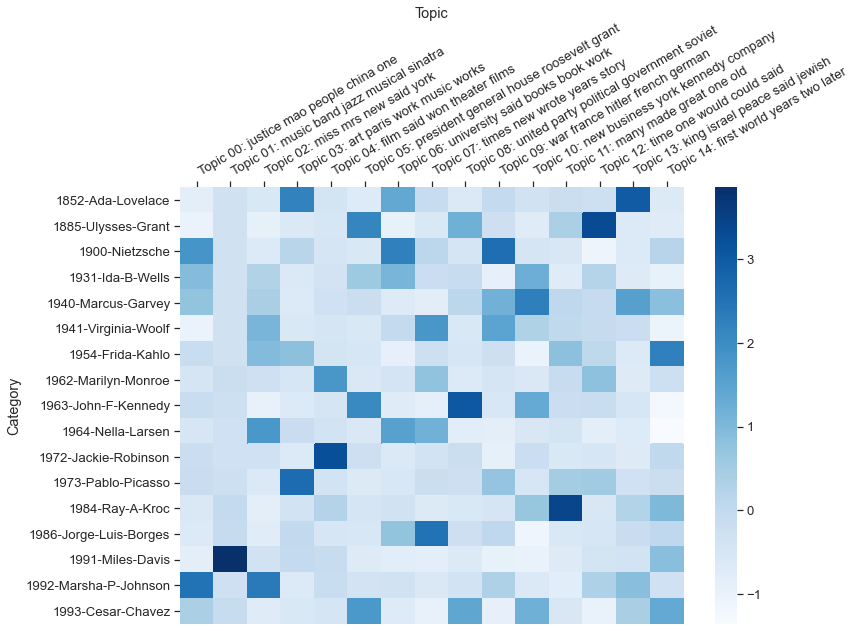

In [114]:
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Blues',
                                 dim=(12,9))
# For all possible color maps, see https://matplotlib.org/stable/tutorials/colors/colormaps.html#miscellaneous

## Output a CSV File

In [295]:
import pandas as pd

topic_results = []
for title, topic_distribution in zip(titles, topic_distributions):
    topic_results.append({'document': title, 'topic_distribution': topic_distribution})

df = pd.DataFrame(topic_results)
column_names = [f"Topic {number} {' '.join(topic[:4])}" for number, topic in enumerate(topic_individual_words)]
df[column_names] = pd.DataFrame(df['topic_distribution'].tolist(), index = df.index)
df = df.drop('topic_distribution', axis='columns')

In [296]:
df.sort_values(by='Topic 1 music band jazz musical', ascending=False)[:6]

,document,Topic 0 justice mao people china,Topic 1 music band jazz musical,Topic 2 miss mrs new said,Topic 3 art paris work music,Topic 4 film said won theater,Topic 5 president general house roosevelt,Topic 6 university said books book,Topic 7 times new wrote years,Topic 8 united party political government,Topic 9 war france hitler french,Topic 10 new business york kennedy,Topic 11 many made great one,Topic 12 time one would could,Topic 13 king israel peace said,Topic 14 first world years two
348,1983-Earl-Hines,0.007906,0.544610,0.038555,0.042519,0.025110,0.014217,0.041089,0.021447,0.005277,0.001382,0.011608,0.051767,0.097526,0.000686,0.096301
353,1993-Dizzy-Gillespie,0.024084,0.528393,0.031484,0.043529,0.055360,0.016352,0.010973,0.044180,0.011611,0.000369,0.003885,0.038152,0.093532,0.008031,0.090066
288,1986-Benny-Goodman,0.013676,0.474402,0.050973,0.026095,0.089995,0.021075,0.002150,0.066154,0.011995,0.000634,0.028028,0.049893,0.104082,0.000101,0.060748
29,1983-Muddy-Waters,0.005809,0.456999,0.045837,0.025924,0.043357,0.023356,0.001547,0.039821,0.004401,0.005462,0.072327,0.074951,0.093166,0.000368,0.106676
235,1991-Miles-Davis,0.022562,0.454112,0.056319,0.053344,0.041184,0.001498,0.017097,0.021428,0.008796,0.000383,0.008107,0.051834,0.115040,0.005894,0.142403
164,1984-Count-Basie,0.010085,0.446898,0.079568,0.016267,0.062421,0.018945,0.001576,0.050305,0.003017,0.000374,0.051617,0.077578,0.104258,0.000186,0.076907


In [294]:
df.to_csv('Topic-Distributions.csv', encoding='utf-8', index=False)

## Your Turn!

Choose a topic from the results above and write down its corresponding topic number below.

**Topic: *Your Number Choice Here***

**1.** Display the top 6 obituary titles for this topic.

In [554]:
#Your Code Here

**2.** Display the topic words in the context of the original obituary for these 6 top titles.

In [554]:
#Your Code Here

**3.** Come up with a label for your topic and write it below:

**Topic Label: *Your Label Here***

**Reflection**

**4.** Why did you label your topic the way you did? What do you think this topic means in the context of all the *NYT* obituaries?

**#**Your answer here

**5.** What's another collection of texts that you think might be interesting to topic model? Why?

**#**Your answer here